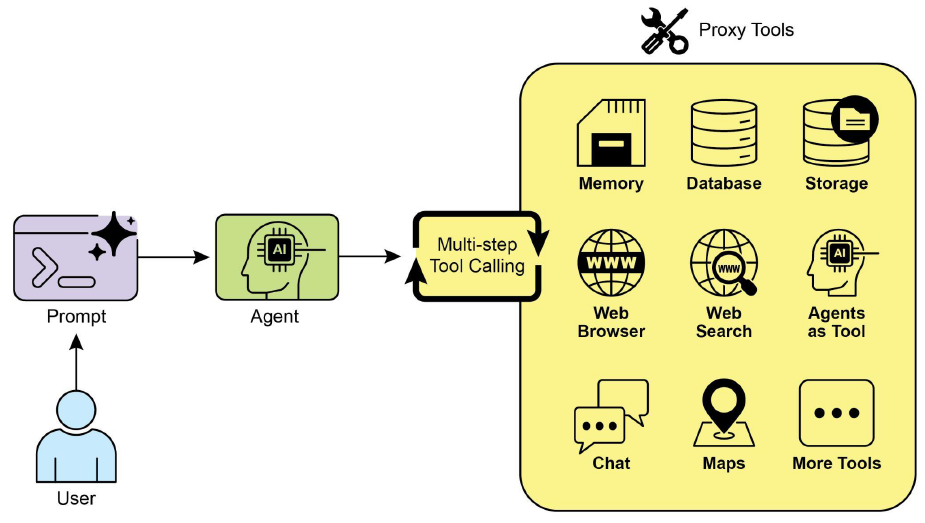


## 🧩 Tool Use Pattern

The **Tool Use Pattern** (or **Function Calling**) enables an agent to **interact with external systems** — APIs, databases, services, or code — extending its capabilities beyond static language understanding. It allows an LLM to decide **when and how** to call tools dynamically during task execution.

---

### ⚙️ Core Process

| **Step** | **Description** |
|:--:|:--|
| **1. Tool Definition** | Define external functions or APIs with names, purposes, and parameters. |
| **2. LLM Decision** | LLM decides if a tool is needed based on the user’s request. |
| **3. Function Call Generation** | LLM outputs structured JSON specifying which tool to call and with what arguments. |
| **4. Tool Execution** | The agent framework runs the actual external function/API. |
| **5. Observation** | The tool’s output is returned to the agent. |
| **6. LLM Processing** | LLM integrates tool output to form a final answer or trigger further actions. |

---

### 🧠 Why It Matters
Tool Use **bridges the gap** between LLM reasoning and real-world functionality — enabling access to **real-time data**, **custom user contexts**, and **action execution** beyond text generation.

---

### 🧰 Tool vs. Function Calling
- **Function Calling** → Traditional execution of defined functions.
- **Tool Calling** → A broader concept including APIs, databases, or even other specialized agents.

This shift allows agents to **orchestrate diverse digital resources** — making them adaptive, extensible, and intelligent.

---

### 🧩 Framework Support
Frameworks like **LangChain**, **LangGraph**, and **Google ADK** provide built-in mechanisms to define tools and integrate them into LLM workflows.

---

### 💡 Practical Applications

| **Domain** | **Use Case** | **Tool Example** | **Outcome** |
|:--|:--|:--|:--|
| **Information Retrieval** | Weather Agent | Weather API | Fetches real-time weather data for any location. |
| **Database/API Interaction** | E-commerce Agent | Inventory & Order APIs | Checks stock, order status, and processes payments. |
| **Data Analysis** | Financial Agent | Stock API + Calculator | Retrieves stock data, performs profit analysis. |
| **Communication** | Personal Assistant | Email API | Sends messages or emails on behalf of the user. |
| **Code Execution** | Coding Assistant | Code Interpreter | Runs snippets safely and returns results. |
| **System Control** | Smart Home Agent | IoT/Smart Light API | Executes commands like turning off lights or adjusting devices. |

---

### 🧭 Key Insight
> Tool Use transforms an LLM from a **passive text generator** into an **active agent** — capable of sensing, reasoning, and acting across digital and physical environments.


## Weather Agent

In [16]:
from typing import Annotated, TypedDict, Any, Optional
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

from langgraph.graph import START, END, StateGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.errors import InvalidUpdateError

from IPython.display import display, Image
import operator
import requests

In [17]:
load_dotenv()

True

#### Using `https://open-meteo.com/en/docs`

In [18]:
# 1. Define State
# -----------------------------
class WeatherState(TypedDict):
    city: str
    lat: Optional[float]
    lon: Optional[float]
    weather: Optional[str]
    error: Optional[str]
    messages: list

In [20]:
# -----------------------------
# 2. External Tool Functions
# -----------------------------
def get_coordinates(city: str):
    """Fetch latitude/longitude for a given city."""
    try:
        url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}"
        resp = requests.get(url, timeout=8) # wait for 8 seconds
        resp.raise_for_status() # continues or raise an exception
        data = resp.json() # Parses the HTTP response body as JSON.
        if not data.get("results"):
            return None, None, f"City '{city}' not found"
        coords = data["results"][0]
        return coords["latitude"], coords["longitude"], None
    except Exception as e:
        return None, None, str(e)


In [21]:
def get_weather(lat: float, lon: float):
    """Fetch current weather using Open-Meteo API."""
    try:
        url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true"
        resp = requests.get(url, timeout=8)
        resp.raise_for_status()
        data = resp.json()
        cw = data.get("current_weather", {})
        if not cw:
            return None, "Weather data unavailable"
        return f"{cw['temperature']}°C, wind {cw['windspeed']} km/h", None
    except Exception as e:
        return None, str(e)

In [22]:
# -----------------------------
# 3. Graph Node Functions
# -----------------------------
def classify_city(state: WeatherState) -> WeatherState:
    """Extract city name from user input."""
    user_msg = state["messages"][-1]["content"].strip()
    return {**state, "city": user_msg}

def fetch_coordinates(state: WeatherState) -> WeatherState:
    lat, lon, error = get_coordinates(state["city"])
    return {**state, "lat": lat, "lon": lon, "error": error}

def fetch_weather(state: WeatherState) -> WeatherState:
    if state.get("error"):
        return state
    weather, error = get_weather(state["lat"], state["lon"])
    return {**state, "weather": weather, "error": error}

def summarize_result(state: WeatherState) -> WeatherState:
    if state.get("error"):
        response = f"⚠️ Error: {state['error']}"
    else:
        response = f"The current weather in **{state['city']}** is {state['weather']}."
    messages = add_messages(state["messages"], [{"role": "assistant", "content": response}])
    return {**state, "messages": messages}

In [23]:
# -----------------------------
# 4. Build LangGraph
# -----------------------------
builder = StateGraph(WeatherState)

builder.add_node("classify_city", classify_city)
builder.add_node("fetch_coordinates", fetch_coordinates)
builder.add_node("fetch_weather", fetch_weather)
builder.add_node("summarize_result", summarize_result)

# Correct linear chain (fully connected)
builder.add_edge(START, "classify_city")
builder.add_edge("classify_city", "fetch_coordinates")
builder.add_edge("fetch_coordinates", "fetch_weather")
builder.add_edge("fetch_weather", "summarize_result")
builder.add_edge("summarize_result", END)

app = builder.compile()

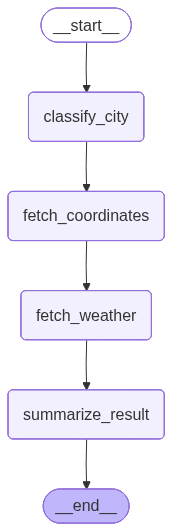

In [24]:
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
city = input("🌤️ Enter a city name: ")
initial_state = {"messages": [{"role": "user", "content": city}]}
final_state = app.invoke(initial_state)

🌤️ Enter a city name:  delhi


In [39]:
from pprint import pprint

In [40]:
pprint(final_state)

{'city': 'delhi',
 'error': None,
 'lat': 28.65195,
 'lon': 77.23149,
 'messages': [HumanMessage(content='delhi', additional_kwargs={}, response_metadata={}, id='86044070-98bf-4d11-b148-ef7001253ba0'),
              AIMessage(content='The current weather in **delhi** is 26.4°C, wind 3.5 km/h.', additional_kwargs={}, response_metadata={}, id='32d23f49-d561-4a78-b0f2-766b63bf6da9')],
 'weather': '26.4°C, wind 3.5 km/h'}


In [38]:
print(final_state["messages"][-1].content)

The current weather in **delhi** is 26.4°C, wind 3.5 km/h.
